# SHAKTI FEniCS code

The code requires [FEniCSx](https://fenicsproject.org). 

Various imports:

In [52]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')

import numpy as np
from dolfinx.io import gmshio
from mpi4py import MPI
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from netCDF4 import Dataset
from load_lakes import gdf
from scipy.interpolate import RegularGridInterpolator
from dolfinx.fem import Function, functionspace,locate_dofs_topological
from dolfinx.mesh import locate_entities_boundary
from params import rho_i, rho_w, g

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
domain, cell_tags, facet_tags = gmshio.read_from_msh("mesh.msh", MPI.COMM_WORLD, gdim=2)
V0 = functionspace(domain, ("CG", 1))

Info    : Reading 'mesh.msh'...
Info    : 301 entities
Info    : 1307 nodes
Info    : 2462 elements
Info    : Done reading 'mesh.msh'


In [3]:
lake_name = 'Cook_E2' 
outline = gdf.loc[gdf['name']==lake_name]
x0 = float(outline.centroid.x.iloc[0])*1e3
y0 = float(outline.centroid.y.iloc[0])*1e3

# Select half-width L0 of box surrounding lake
L0 = 50*1000
x_min = x0-L0
x_max = x0+L0
y_min = y0-L0
y_max = y0+L0

In [4]:
# load surface elevation, make interpolation, and interpolate onto mesh nodes
ds = Dataset('/Users/agstubbl/Desktop/ICESat-2/ATL14_A4_0325_100m_004_05.nc'  )

h = ds['h'][:]               # elevation (m)
x = ds['x'][:]               # x coordinate array (m)
y = ds['y'][:]               # y coordinate array (m)

# extract the data that is inside the bounding box
ind_x = np.arange(0,np.size(x),1)
ind_y = np.arange(0,np.size(y),1)
x_sub = x[(x>=x_min)&(x<=x_max)].filled()
y_sub = y[(y>=y_min)&(y<=y_max)].filled()
inds_x = ind_x[(x>=x_min)&(x<=x_max)]
inds_y = ind_y[(y>=y_min)&(y<=y_max)]

nx = np.size(inds_x)
ny = np.size(inds_y)

inds_xy = np.ix_(inds_y,inds_x)
h_sub = np.zeros((ny,nx))

# put elevation change maps into 3D array with time being the first index
h_sub = h[inds_xy].filled().T

h_interp = RegularGridInterpolator((x_sub, y_sub), h_sub, bounds_error=False, fill_value=None)

# define dolfinx function for the surface elevation
z_s = Function(V0)
z_s.x.array[:] = h_interp( (domain.geometry.x[:,0],domain.geometry.x[:,1]) )

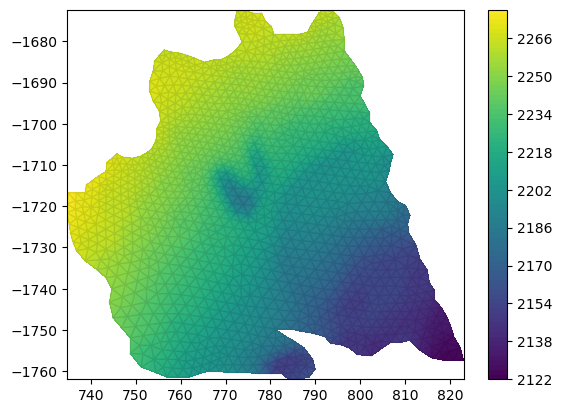

In [5]:
# plot to make sure it worked
triang = Triangulation(domain.geometry.x[:,0]/1e3,domain.geometry.x[:,1]/1e3,domain.geometry.dofmap)
plt.tricontourf(triang,z_s.x.array,levels=100)
plt.triplot(triang.x, triang.y, triang.triangles,linewidth=1,color='k',alpha=0.1)
plt.title('surface elecation',fontsize=20)
plt.colorbar()
plt.show()
plt.close()

In [11]:
# Interpolate bedmachine thickness onto mesh and plot
bedmachine = Dataset('/Users/agstubbl/Desktop/bedmachine/BedMachineAntarctica-v3.nc')
x_bm = bedmachine['x'][:].data.astype(np.float64)
y_bm = np.flipud(bedmachine['y'][:].data.astype(np.float64))
H_bm = np.flipud(bedmachine['thickness'][:].data.astype(np.float64))
bed_bm = np.flipud(bedmachine['bed'][:].data.astype(np.float64))
xb_sub = x_bm[(x_bm>=x_min)&(x_bm<=x_max)]
yb_sub = y_bm[(y_bm>=y_min)&(y_bm<=y_max)]
ind_x = np.arange(0,np.size(x_bm),1)
ind_y = np.arange(0,np.size(y_bm),1)
inds_x = ind_x[(x_bm>=x_min)&(x_bm<=x_max)]
inds_y = ind_y[(y_bm>=y_min)&(y_bm<=y_max)]
nx = np.size(inds_x)
ny = np.size(inds_y)
inds_xy = np.ix_(inds_y,inds_x)
bed_sub = np.zeros((ny,nx))
bed_sub = bed_bm[inds_xy].T
bed_interp = RegularGridInterpolator((xb_sub, yb_sub), bed_sub, bounds_error=False, fill_value=None)

# define dolfinx function for the surface elevation
z_b = Function(V0)
z_b.x.array[:] = bed_interp( (domain.geometry.x[:,0],domain.geometry.x[:,1]) )


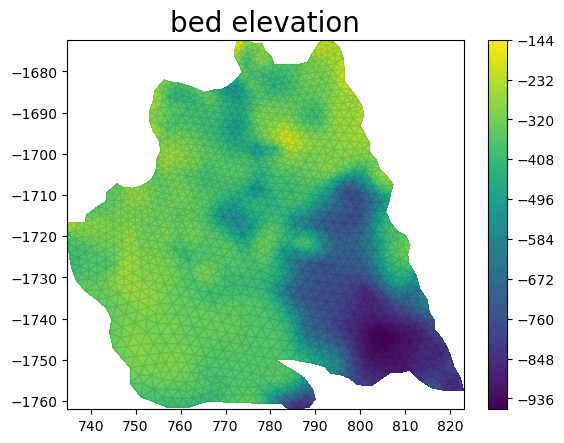

In [13]:
plt.tricontourf(triang,z_b.x.array,levels=100)
plt.triplot(triang.x, triang.y, triang.triangles,linewidth=1,color='k',alpha=0.1)
plt.title('bed elevation',fontsize=20)
plt.colorbar()
plt.show()
plt.close()

In [49]:
potential = Function(V0)
potential.x.array[:] = rho_i*g*z_s.x.array[:] + (rho_w-rho_i)*g*z_b.x.array[:]

In [53]:
P_min = potential.x.array.min()
P_std = np.std(potential.x.array)

potential_interp = lambda x,y: rho_i*g*h_interp((x,y)) + (rho_w-rho_i)*g*bed_interp((x,y))

def OutflowBoundary(x):
    return np.less(np.abs(potential_interp(x[0],x[1])-P_min),0.5*P_std)

facets_outflow = locate_entities_boundary(domain, domain.topology.dim-1, OutflowBoundary)
outflow_dofs = locate_dofs_topological(V0, domain.topology.dim-1, facets_outflow)

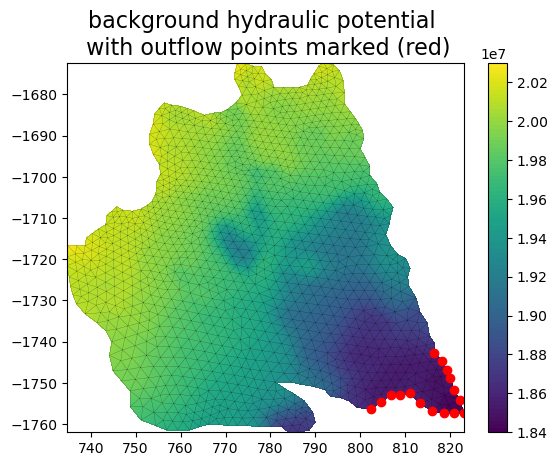

In [59]:
plt.tricontourf(triang,potential.x.array,levels=100)
plt.triplot(triang.x, triang.y, triang.triangles,linewidth=0.1,color='k',alpha=1)
plt.plot(domain.geometry.x[outflow_dofs,0]/1e3,domain.geometry.x[outflow_dofs,1]/1e3,'ro')
plt.title('background hydraulic potential \n with outflow points marked (red)',fontsize=16)
plt.colorbar()
plt.show()
plt.close()